In [1]:
%matplotlib inline
from copy import deepcopy as copy
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from disp import set_font_size, set_n_x_ticks, set_n_y_ticks
from replay import analysis

cc = np.concatenate


HMAP_PARAMS = {
    'FR_NTRJ_MIN_BLOWUP': 1.5,  # Hz
    'FR_NTRJ_TRJ_BLOWUP_RATIO': .3,  # frac
    'MIN_EVTS_ONE_WAY_FRAC_CALC': 5,
}

SCT_SIZE = 150

def evt_frq_hmap(f_name, v_mins, v_maxs, x_ticks, c_ticks, hmap_params):
    """Make heatmaps of spontaneous replay event frequency given param sweep file."""
    
    df, rslts, header = analysis.make_df(f_name)
    params_varied = header['params_varied']
    assert len(params_varied) == 2
    
    n_trials = header['sweep_params']['N_TRIALS']
    dur = header['s_params']['schedule']['D_SMLN'] - header['a_params']['MIN_START']
    
    # get data into numpy arrays
    p_0 = np.array(df[params_varied[0]])
    p_1 = np.array(df[params_varied[1]])
    
    p_0_min = np.min(p_0)
    p_0_max = np.max(p_0)
    p_0_range = p_0_max - p_0_min
    
    p_1_min = np.min(p_1)
    p_1_max = np.max(p_1)
    p_1_range = p_1_max - p_1_min
    
    fr_trj = np.array(df['FR_TRJ'])
    fr_ntrj = np.array(df['FR_NTRJ'])
    
    print('Min fr_trj = ', np.nanmin(fr_trj), 'Hz')
    print('Max fr_trj = ', np.nanmax(fr_trj), 'Hz')
    print('Min fr_ntrj = ', np.nanmin(fr_ntrj), 'Hz')
    print('Max fr_ntrj = ', np.nanmax(fr_ntrj), 'Hz')
    
    evt_ct = np.array(df['EVT_CT'])
    evt_frq = evt_ct / dur
    
    print('Min evt_ct = ', np.min(evt_ct))
    print('Max evt_ct = ', np.max(evt_ct))
    print('Min evt_frq = ', np.min(evt_frq), 'Hz')
    print('Max evt_frq = ', np.max(evt_frq), 'Hz')
    
    one_way_ct = np.array(df['ONE_WAY_CT'])
    one_way_frq = one_way_ct / dur
    
    print('Min one_way_ct', np.min(one_way_ct))
    print('Max one_way_ct', np.max(one_way_ct))
    
    # make plots
    fig, axs = plt.subplots(3, 2, figsize=(12.5, 15), tight_layout=True)
    
    ## fr trj
    im_00 = axs[0, 0].scatter(p_0, p_1, SCT_SIZE, c=fr_trj, marker='s', vmin=v_mins['fr_trj'], vmax=v_maxs['fr_trj'])
    axs[0, 0].set_title('LTP-IE-tagged firing rates')
    cb_00 = fig.colorbar(im_00, ax=axs[0, 0])
    cb_00.set_label('Firing rate (Hz)', fontsize=16)

    ## fr ntrj
    im_01 = axs[0, 1].scatter(p_0, p_1, SCT_SIZE, c=fr_ntrj, marker='s', vmin=v_mins['fr_ntrj'], vmax=v_maxs['fr_ntrj'])
    axs[0, 1].set_title('Non-LTP-IE-tagged firing rates')
    cb_01 = fig.colorbar(im_01, ax=axs[0, 1])
    cb_01.set_label('Firing rate (Hz)', fontsize=16)
    
    ## evt frq
    im_10 = axs[1, 0].scatter(p_0, p_1, SCT_SIZE, c=evt_frq, marker='s', vmin=v_mins['evt_frq'], vmax=v_maxs['evt_frq'])
    axs[1, 0].set_title('Event frequency')
    cb_10 = fig.colorbar(im_10, ax=axs[1, 0])
    cb_10.set_label('Event frequency (Hz)', fontsize=16)
    
    ## replay zones
    ### plot event freq
    im_11 = axs[1, 1].scatter(
        p_0, p_1, SCT_SIZE, c=evt_frq, marker='s', vmin=v_mins['evt_frq'], vmax=v_maxs['evt_frq'], cmap='plasma', zorder=0)
    axs[1, 1].set_title('Replay regimes')
    cb_11 = fig.colorbar(im_11, ax=axs[1, 1], ticks=c_ticks)
    cb_11.set_label('Event frequency (Hz)', fontsize=16)
    
    ### set blowup vals to green
    mask = \
        (fr_ntrj >= hmap_params['FR_NTRJ_MIN_BLOWUP']) \
        | (fr_ntrj / fr_trj >= hmap_params['FR_NTRJ_TRJ_BLOWUP_RATIO'])
    axs[1, 1].scatter(
        p_0[mask], p_1[mask], SCT_SIZE+2, c='k', marker='s', zorder=2)
        
    c_tick_labels = [str(c_tick) for c_tick in c_ticks]
    c_tick_labels[-1] = '>{}'.format(c_ticks[-1])

    cb_11.ax.set_yticklabels(c_tick_labels)
    
    ## plot frequency of one-way events
    im_20 = axs[2, 0].scatter(p_0, p_1, SCT_SIZE, c=one_way_frq, marker='s', vmin=v_mins['evt_frq'], vmax=v_maxs['evt_frq'])
    axs[2, 0].set_title('One-way frequency')
    cb_20 = fig.colorbar(im_20, ax=axs[2, 0])
    cb_20.set_label('One-way frequency (Hz)', fontsize=16)
    
    ## plot fraction of one-way events
    ### put trial-wise total event counts into np array
    evt_cts_trials = np.transpose([np.array(df['EVT_CT_{}'.format(ctr)]) for ctr in range(n_trials)])
    ### put trial-wise one-way event counts into np array
    one_way_cts_trials = np.transpose([np.array(df['ONE_WAY_CT_{}'.format(ctr)]) for ctr in range(n_trials)])
    
    ### get trial-wise one-way count fractions
    #### set evt cts to nan if less than min evts to use for one-way frac calc
    evt_cts_trials[evt_cts_trials < hmap_params['MIN_EVTS_ONE_WAY_FRAC_CALC']]
    #### divide
    one_way_fracs_trials = one_way_cts_trials / evt_cts_trials
    #### take mean across trials
    one_way_fracs = np.nanmean(one_way_fracs_trials, axis=1)
    
    ## plot one-way event fractions
    im_21 = axs[2, 1].scatter(p_0, p_1, SCT_SIZE, c=one_way_fracs, vmin=0, vmax=1, marker='s', cmap='cool')
    axs[2, 1].set_title('Unidirectional replay')
    cb_21 = fig.colorbar(im_21, ax=axs[2, 1])
    cb_21.set_label('Fraction unidirectional', fontsize=16)
    
    ## set blowup vals to green
    mask = \
        (fr_ntrj >= hmap_params['FR_NTRJ_MIN_BLOWUP']) \
        | (fr_ntrj / fr_trj >= hmap_params['FR_NTRJ_TRJ_BLOWUP_RATIO'])
    axs[2, 1].scatter(
        p_0[mask], p_1[mask], SCT_SIZE+2, c='k', marker='s', zorder=2)
    
    for ax in axs.flatten():
        
        ax.set_xlim(p_0_min - .05*p_0_range, p_0_max + .05*p_0_range)
        ax.set_ylim(p_1_min - .05*p_1_range, p_1_max + .05*p_1_range)
        
        if x_ticks is not None:
            ax.set_xticks(x_ticks)
        
        ax.set_xlabel(params_varied[0])
        ax.set_ylabel(params_varied[1])
        
        ax.set_facecolor((.8, .8, .8))
        set_font_size(ax, 16)
        
    set_font_size(axs[2, 1], 20)
        
    for cb in [cb_00, cb_01, cb_10, cb_11]:
        
        set_font_size(cb.ax, 16)
    
    set_font_size(cb_21.ax, 20)
    
    return df, rslts, header

/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Min fr_trj =  2.620115629984053 Hz
Max fr_trj =  18.783534435438582 Hz
Min fr_ntrj =  0.009121474721685462 Hz
Max fr_ntrj =  18.75947336069609 Hz
Min evt_ct =  0.0
Max evt_ct =  69.9
Min evt_frq =  0.0 Hz
Max evt_frq =  7.1692307692307695 Hz
Min one_way_ct 0.0
Max one_way_ct 34.0


/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in greater_equal
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in true_divide
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/ipykernel_launcher.py:125: RuntimeWarning: Mean of empty slice
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in greater_equal


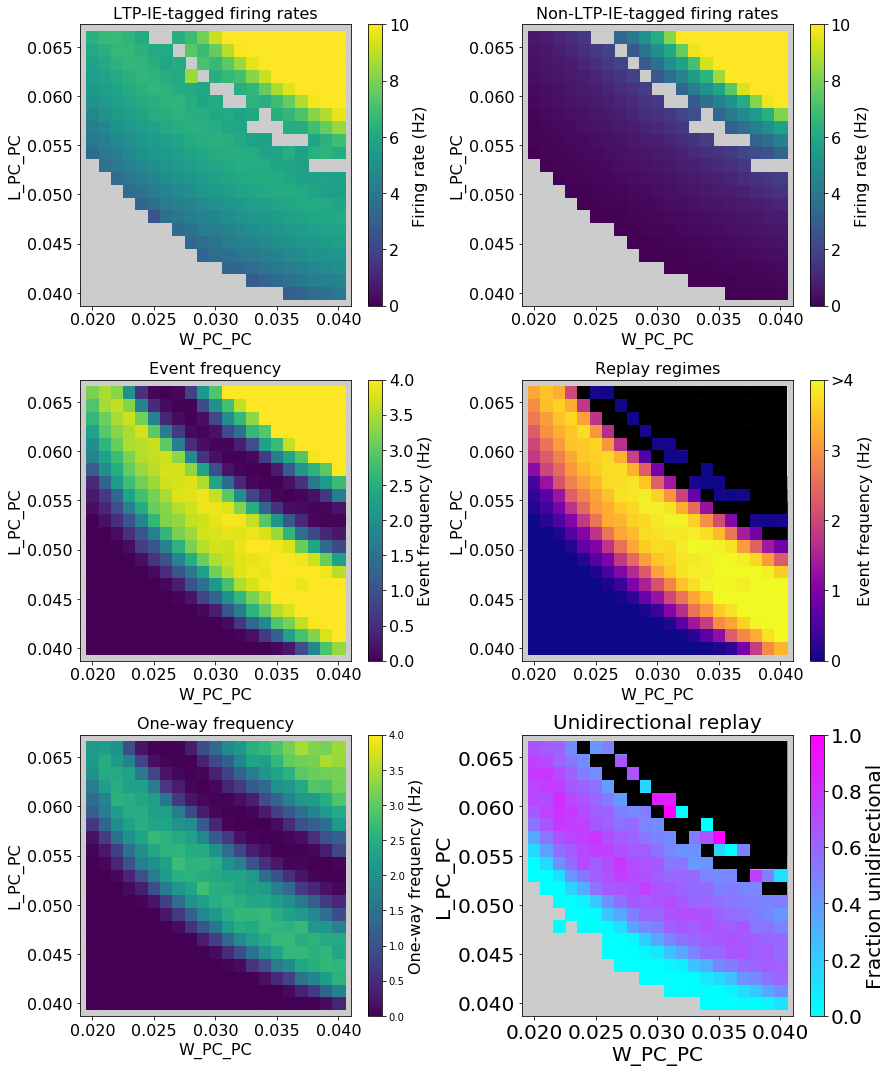

In [2]:
v_mins = {'fr_trj': 0, 'fr_ntrj': 0, 'evt_frq': 0}
v_maxs = {'fr_trj': 10, 'fr_ntrj': 10, 'evt_frq': 4}
x_ticks = [0.02, 0.025, 0.03, 0.035, 0.04]
c_ticks = [0, 1, 2, 3, 4]

dfs, rslts, header = evt_frq_hmap(
    'PARAM_SWEEP_RESULTS_0_W_PC_PC_L_PC_PC.txt',
    v_mins, v_maxs, x_ticks, c_ticks,
    HMAP_PARAMS)

/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Min fr_trj =  3.5414298388423195 Hz
Max fr_trj =  16.901286160727615 Hz
Min fr_ntrj =  0.04044118528460312 Hz
Max fr_ntrj =  16.806344190740372 Hz
Min evt_ct =  0.1
Max evt_ct =  74.9
Min evt_frq =  0.010256410256410256 Hz
Max evt_frq =  7.682051282051282 Hz
Min one_way_ct 0.0
Max one_way_ct 29.2


/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in greater_equal
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in true_divide
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in greater_equal


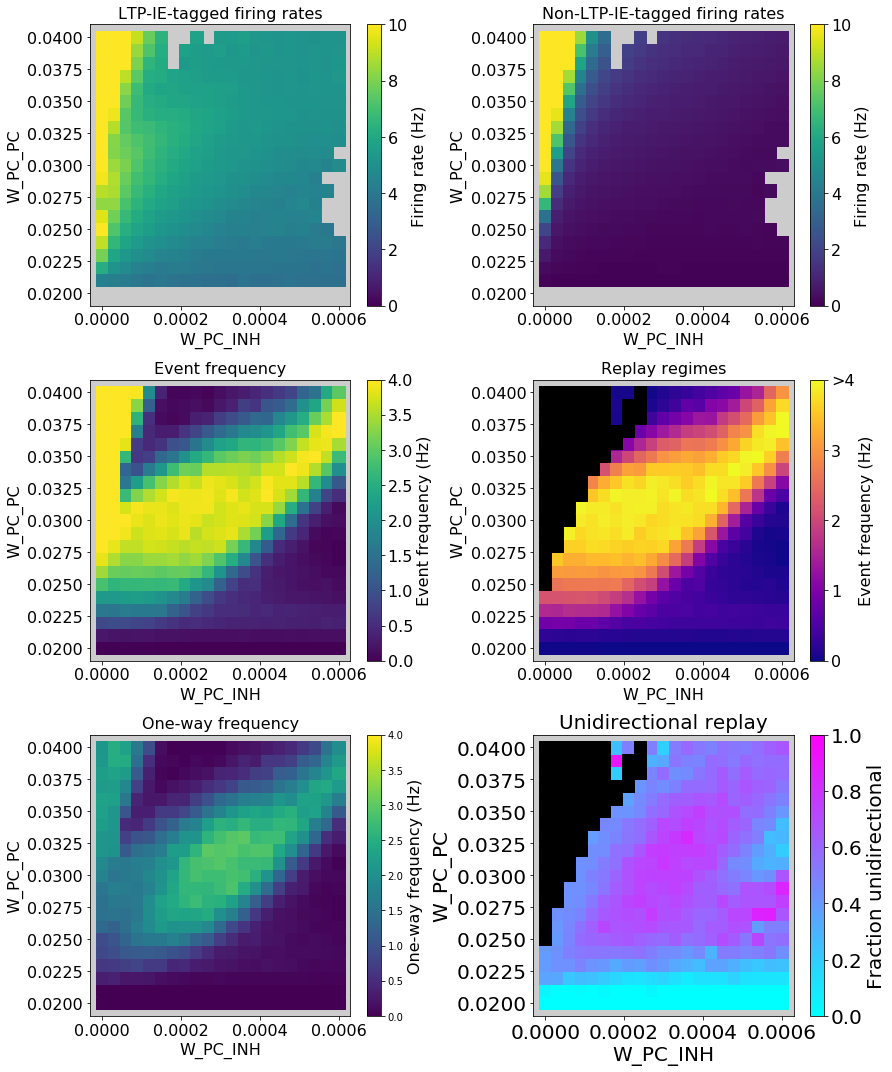

In [3]:
v_mins = {'fr_trj': 0, 'fr_ntrj': 0, 'evt_frq': 0}
v_maxs = {'fr_trj': 10, 'fr_ntrj': 10, 'evt_frq': 4}
x_ticks = [0.0, .0002, 0.0004, 0.0006]
c_ticks = [0, 1, 2, 3, 4]

dfs, rslts, header = evt_frq_hmap(
    'PARAM_SWEEP_RESULTS_1_W_PC_PC_W_PC_INH.txt',
    v_mins, v_maxs, x_ticks, c_ticks,
    HMAP_PARAMS)

/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Min fr_trj =  3.460852014320366 Hz
Max fr_trj =  8.437004025769339 Hz
Min fr_ntrj =  0.018612305320347012 Hz
Max fr_ntrj =  2.460679239907694 Hz
Min evt_ct =  0.0
Max evt_ct =  71.8
Min evt_frq =  0.0 Hz
Max evt_frq =  7.364102564102564 Hz
Min one_way_ct 0.0
Max one_way_ct 32.4


/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in greater_equal
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in true_divide
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/ipykernel_launcher.py:125: RuntimeWarning: Mean of empty slice
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in greater_equal


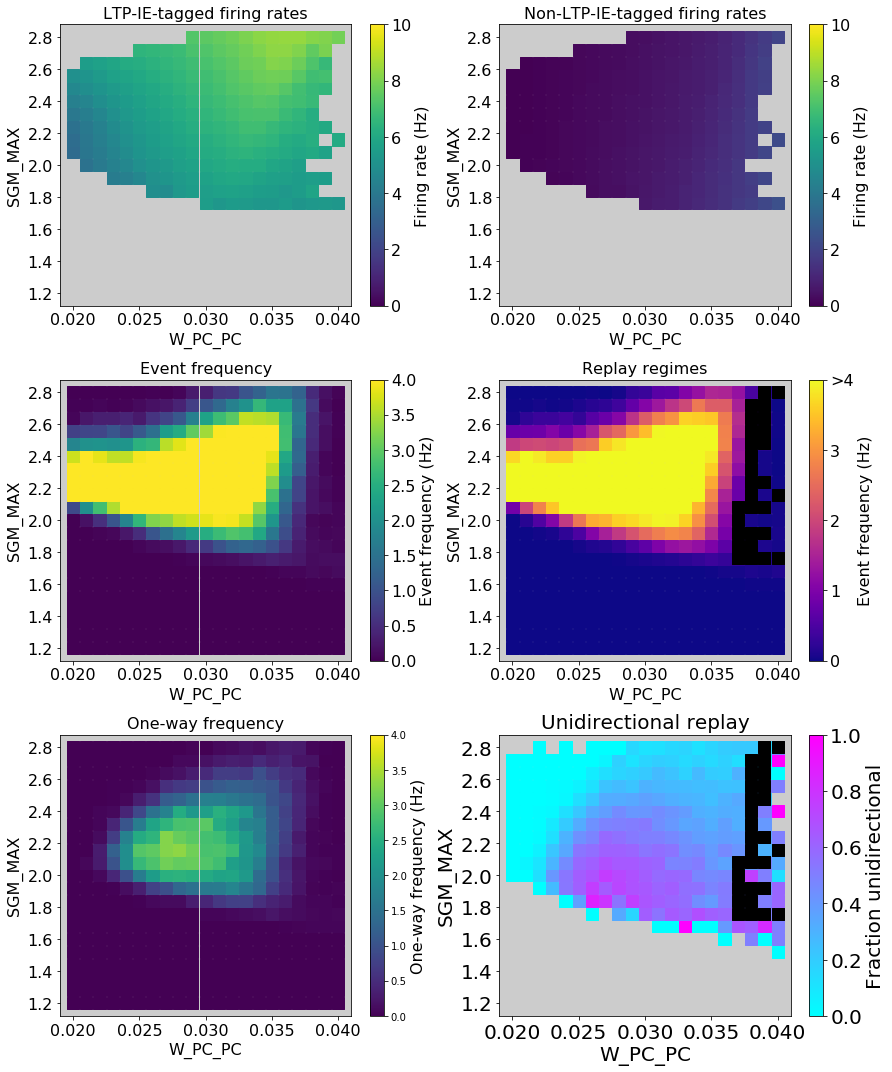

In [4]:
v_mins = {'fr_trj': 0, 'fr_ntrj': 0, 'evt_frq': 0}
v_maxs = {'fr_trj': 10, 'fr_ntrj': 10, 'evt_frq': 4}
x_ticks = [0.02, 0.025, 0.03, 0.035, 0.04]
c_ticks = [0, 1, 2, 3, 4]

dfs, rslts, header = evt_frq_hmap(
    'PARAM_SWEEP_RESULTS_2_W_PC_PC_SGM_MAX.txt',
    v_mins, v_maxs, x_ticks, c_ticks,
    HMAP_PARAMS)

/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Min fr_trj =  3.277344705236386 Hz
Max fr_trj =  19.54196725992109 Hz
Min fr_ntrj =  0.024967464967982005 Hz
Max fr_ntrj =  19.406589578156744 Hz
Min evt_ct =  0.0
Max evt_ct =  63.4
Min evt_frq =  0.0 Hz
Max evt_frq =  6.5025641025641026 Hz
Min one_way_ct 0.0
Max one_way_ct 28.5


/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in greater_equal
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in true_divide
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/ipykernel_launcher.py:125: RuntimeWarning: Mean of empty slice
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in greater_equal


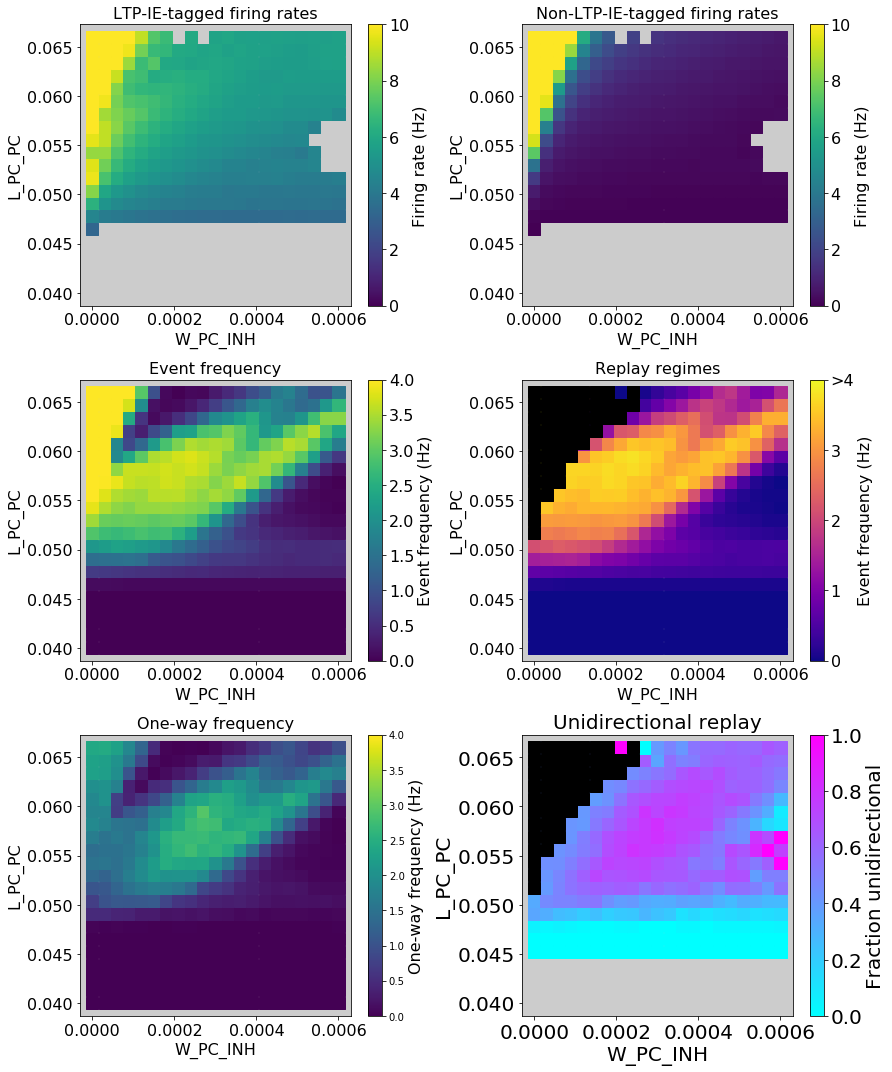

In [5]:
v_mins = {'fr_trj': 0, 'fr_ntrj': 0, 'evt_frq': 0}
v_maxs = {'fr_trj': 10, 'fr_ntrj': 10, 'evt_frq': 4}
x_ticks = [0.0, .0002, 0.0004, 0.0006]
c_ticks = [0, 1, 2, 3, 4]

dfs, rslts, header = evt_frq_hmap(
    'PARAM_SWEEP_RESULTS_3_L_PC_PC_W_PC_INH.txt',
    v_mins, v_maxs, x_ticks, c_ticks,
    HMAP_PARAMS)

/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Min fr_trj =  4.2790034910579555 Hz
Max fr_trj =  6.9456363977212225 Hz
Min fr_ntrj =  0.10136393151857408 Hz
Max fr_ntrj =  0.581285129019042 Hz
Min evt_ct =  0.0
Max evt_ct =  57.7
Min evt_frq =  0.0 Hz
Max evt_frq =  5.917948717948718 Hz
Min one_way_ct 0.0
Max one_way_ct 37.1


/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in greater_equal
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in true_divide
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/ipykernel_launcher.py:125: RuntimeWarning: Mean of empty slice
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in greater_equal


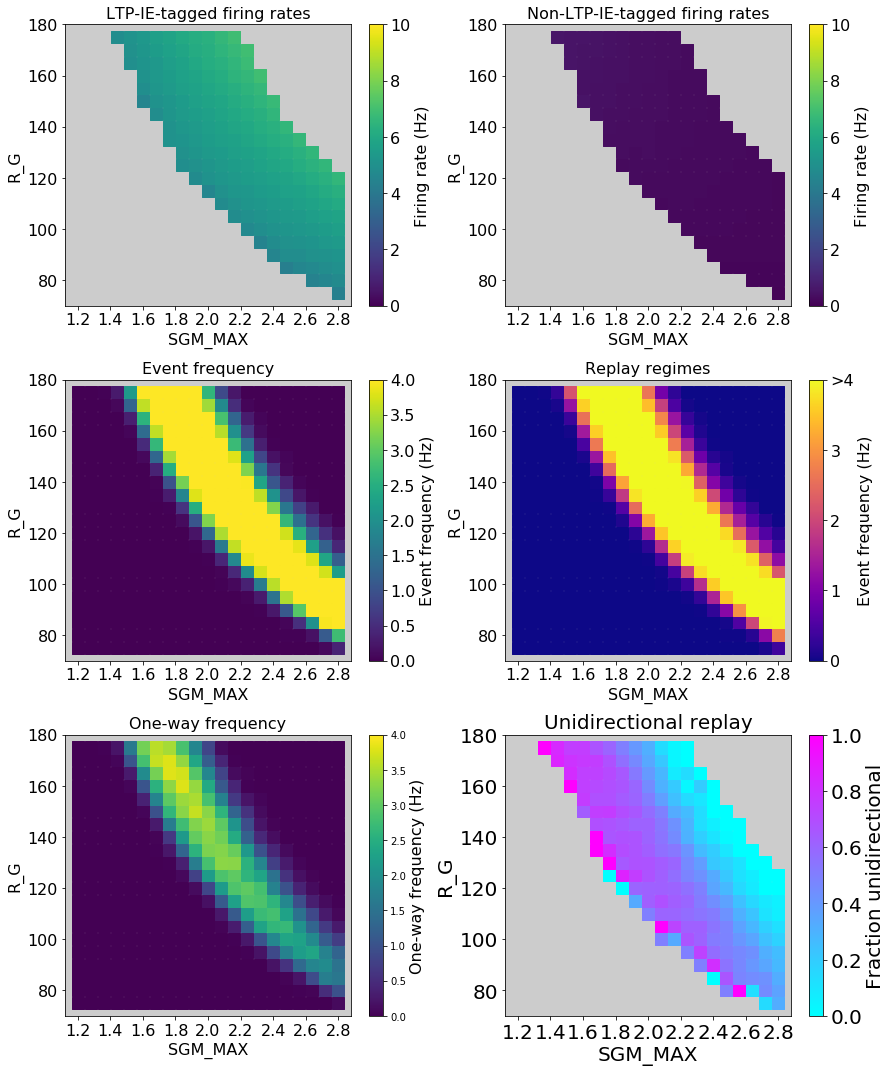

In [6]:
v_mins = {'fr_trj': 0, 'fr_ntrj': 0, 'evt_frq': 0}
v_maxs = {'fr_trj': 10, 'fr_ntrj': 10, 'evt_frq': 4}
x_ticks = None  # [0.0, .0002, 0.0004, 0.0006]
c_ticks = [0, 1, 2, 3, 4]

dfs, rslts, header = evt_frq_hmap(
    'PARAM_SWEEP_RESULTS_4_R_G_SGM_MAX.txt',
    v_mins, v_maxs, x_ticks, c_ticks,
    HMAP_PARAMS)

/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Min fr_trj =  4.170916312040321 Hz
Max fr_trj =  13.15640167793757 Hz
Min fr_ntrj =  0.11670376125032351 Hz
Max fr_ntrj =  10.588740036163824 Hz
Min evt_ct =  0.0
Max evt_ct =  67.9
Min evt_frq =  0.0 Hz
Max evt_frq =  6.964102564102565 Hz
Min one_way_ct 0.0
Max one_way_ct 35.5


/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in greater_equal
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in true_divide
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/ipykernel_launcher.py:125: RuntimeWarning: Mean of empty slice
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in greater_equal


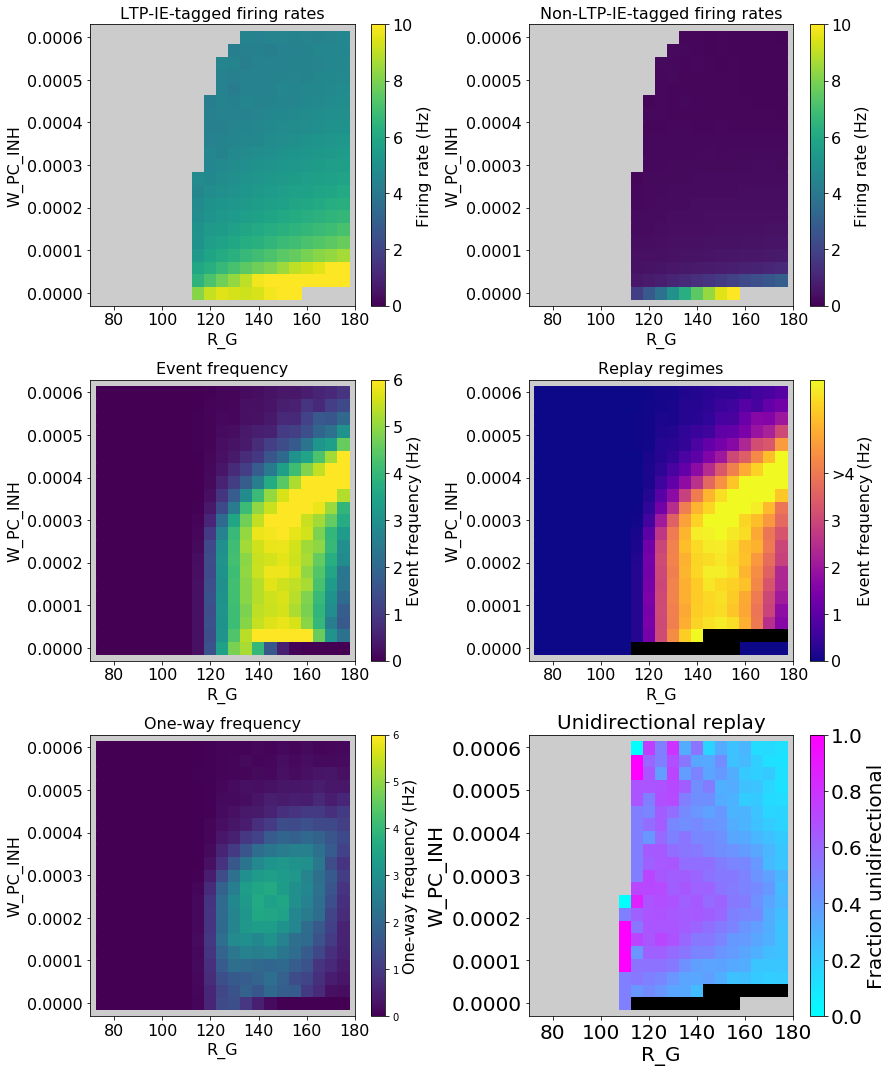

In [7]:
v_mins = {'fr_trj': 0, 'fr_ntrj': 0, 'evt_frq': 0}
v_maxs = {'fr_trj': 10, 'fr_ntrj': 10, 'evt_frq': 6}
x_ticks = None  # [0.0, .0002, 0.0004, 0.0006]
c_ticks = [0, 1, 2, 3, 4]

dfs, rslts, header = evt_frq_hmap(
    'PARAM_SWEEP_RESULTS_5_R_G_W_PC_INH.txt',
    v_mins, v_maxs, x_ticks, c_ticks,
    HMAP_PARAMS)

/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Min fr_trj =  4.350689102755215 Hz
Max fr_trj =  7.01649952292422 Hz
Min fr_ntrj =  0.17084592556290648 Hz
Max fr_ntrj =  0.3893218967683084 Hz
Min evt_ct =  0.0
Max evt_ct =  58.5
Min evt_frq =  0.0 Hz
Max evt_frq =  6.0 Hz
Min one_way_ct 0.0
Max one_way_ct 38.0


/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in greater_equal
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in true_divide
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/ipykernel_launcher.py:125: RuntimeWarning: Mean of empty slice
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/ipykernel_launcher.py:134: RuntimeWarning: invalid value encountered in greater_equal


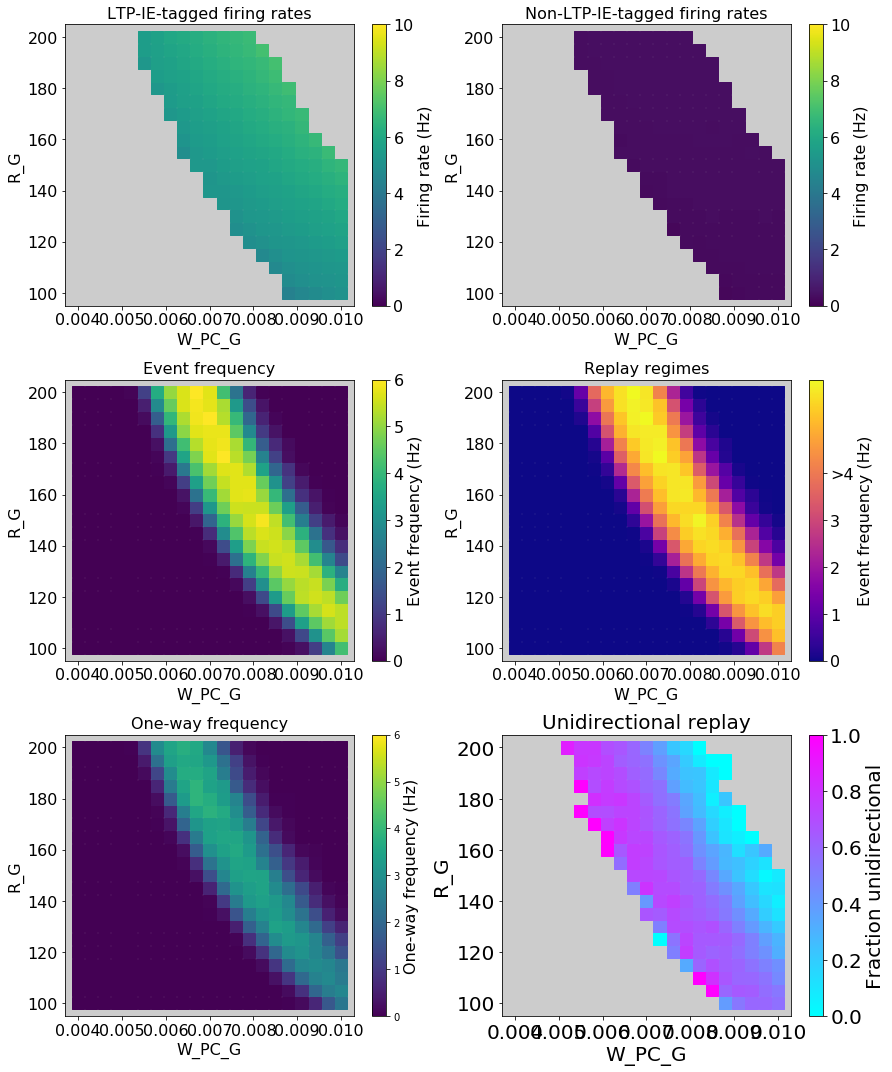

In [8]:
v_mins = {'fr_trj': 0, 'fr_ntrj': 0, 'evt_frq': 0}
v_maxs = {'fr_trj': 10, 'fr_ntrj': 10, 'evt_frq': 6}
x_ticks = None  # [0.0, .0002, 0.0004, 0.0006]
c_ticks = [0, 1, 2, 3, 4]

dfs, rslts, header = evt_frq_hmap(
    'PARAM_SWEEP_RESULTS_6_R_G_W_PC_G.txt',
    v_mins, v_maxs, x_ticks, c_ticks,
    HMAP_PARAMS)